In [48]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [49]:
from mejiro.lenses import lens_util

detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, limit=None, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

best_snr = [l for l in detectable_lenses if l.snr > 50]
print(f'Number of high SNR lenses: {len(best_snr)}')

  7%|▋         | 11/166 [00:00<00:01, 109.02it/s]

100%|██████████| 166/166 [00:04<00:00, 40.20it/s]


Number of detectable lenses: 166
Number of high SNR lenses: 20


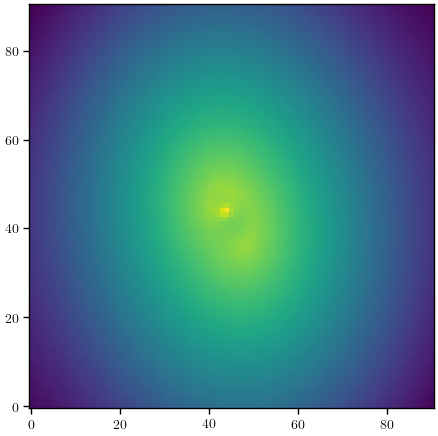

In [50]:
sample_lens = np.random.choice(best_snr)

num_pix = 91
side = 10.01

# generate synthetic image (surface brightness)
sb = sample_lens.get_array(num_pix=num_pix, side=side, band='F129')

plot.plot(np.log10(sb))

In [51]:
realization = sample_lens.realization

from pyHalo.Cosmology.cosmology import Cosmology
Cosmology(astropy_instance=sample_lens.cosmo)
lens_model_list, lens_redshift_array, kwargs_halos, _ = realization.lensing_quantities(add_mass_sheet_correction=True)

In [52]:
pprint(lens_model_list[-1])

'CONVERGENCE'


In [53]:
pprint(kwargs_halos[-1])

{'dec_0': 0.0, 'kappa': -0.010305849173787978, 'ra_0': 0.0}


In [54]:
total_kappa = sample_lens.get_total_kappa(num_pix=num_pix, side=side)
macrolens_kappa = sample_lens.get_macrolens_kappa(num_pix=num_pix, side=side)
subhalo_kappa = sample_lens.get_subhalo_kappa(num_pix=num_pix, side=side)

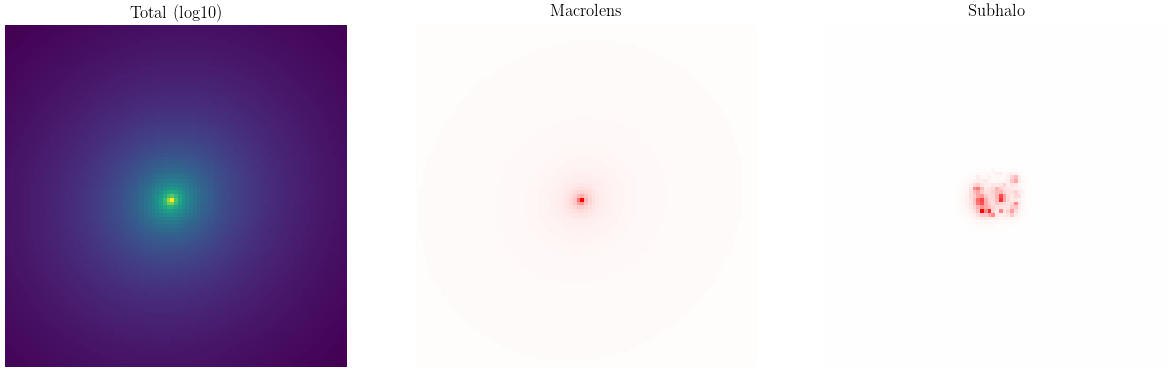

In [55]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(total_kappa))
ax[1].imshow(macrolens_kappa, cmap='bwr', vmin=-np.max(macrolens_kappa), vmax=np.max(macrolens_kappa))
ax[2].imshow(subhalo_kappa, cmap='bwr', vmin=-np.max(subhalo_kappa), vmax=np.max(subhalo_kappa))
ax[0].set_title('Total (log10)')
ax[1].set_title('Macrolens')
ax[2].set_title('Subhalo')
for a in ax: a.axis('off')
plt.show()

In [56]:
lens_cosmo = sample_lens.lens_cosmo

total_proj_mass = lens_cosmo.kappa2proj_mass(total_kappa)
macrolens_proj_mass = lens_cosmo.kappa2proj_mass(macrolens_kappa)
subhalo_proj_mass = lens_cosmo.kappa2proj_mass(subhalo_kappa)

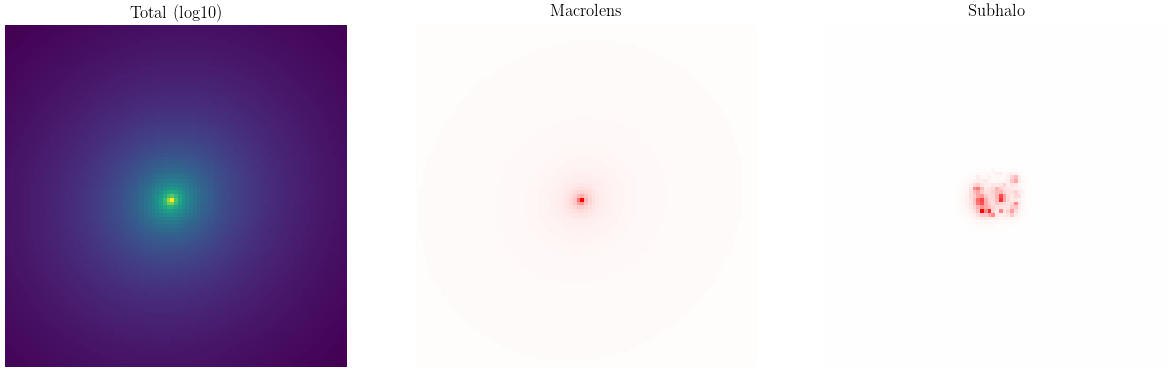

In [57]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(total_proj_mass))
ax[1].imshow(macrolens_proj_mass, cmap='bwr', vmin=-np.max(macrolens_proj_mass), vmax=np.max(macrolens_proj_mass))
ax[2].imshow(subhalo_proj_mass, cmap='bwr', vmin=-np.max(subhalo_proj_mass), vmax=np.max(subhalo_proj_mass))
ax[0].set_title('Total (log10)')
ax[1].set_title('Macrolens')
ax[2].set_title('Subhalo')
for a in ax: a.axis('off')
plt.show()

Check that the negative mass sheet is correctly subtracting the effect of subhalos

In [77]:
pprint(sample_lens.kwargs_lens[-1])

negative_mass_sheet = sample_lens.kwargs_lens[-1]['kappa']

{'dec_0': 0.0, 'kappa': -0.010305849173787978, 'ra_0': 0.0}


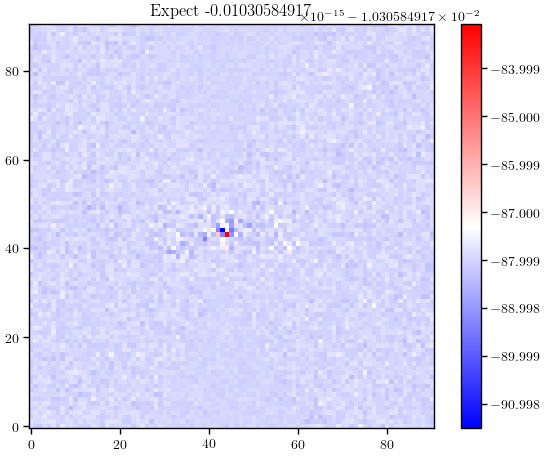

In [79]:
residuals = total_kappa - (macrolens_kappa + subhalo_kappa)

plt.imshow(residuals, cmap='bwr')
plt.colorbar()
plt.title(f'Expect {negative_mass_sheet:.11f}')
plt.show()

So yes, it is. The average lines up exactly with the kappa in the kwargs_lens. The deviations are order 1e-15 which can be chalked up to floating point error

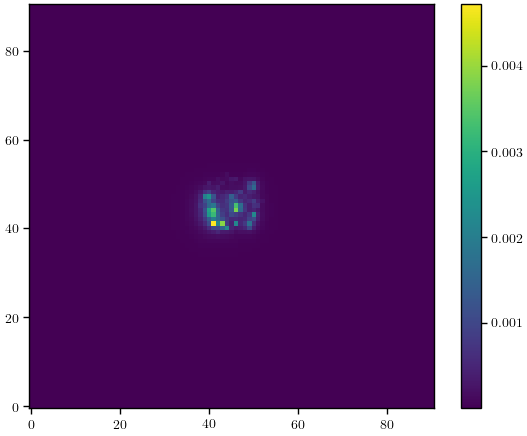

In [58]:
plt.imshow(subhalo_kappa)
plt.colorbar()
plt.show()

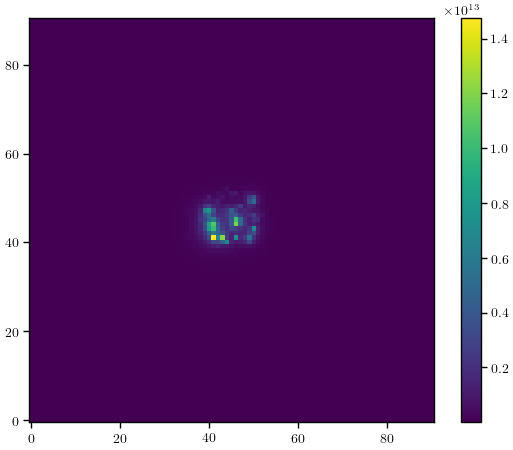

In [59]:
plt.imshow(subhalo_proj_mass)
plt.colorbar()
plt.show()